# Perceptronul multi-strat / Multi-Layer Perceptron (MLP)

Termen de predare: **3 mai 2023, ora 23:00**

Se vor folosi type annotations pentru variabile, parametrii tuturor funcțiilor, tipuri de retur. Tema se noteaza doar in prezenta studentului; rezolvarile sunt individuale.

Se acordă doua puncte din oficiu. Fișierul va fi denumit tema4_ia_nume_prenume.ipynb. Verificați înainte de trimitere faptul ca execuția celulelor de sus în jos funcționează corespunzător. Aserțiunile sunt obligatoriu a fi indeplinite. Suplimentar, puteti face si alte verificari.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', **{'size' : 18})

## 1. Topologia reţelei

învăţarea se bazează tot pe ajustarea ponderilor în direcţia dată de gradientului negativ. De data aceasta funcţia de optimizat va avea ca argumente ponderie straturilor succesive. Vom pleca de la modelul reţelei pentru a da forma funcţiei de cost, care, vom vedea, poate fi privită ca o compunere de funcţii.

O reţea fully connected cu două straturi poate arăta, schematic, în felul următor:

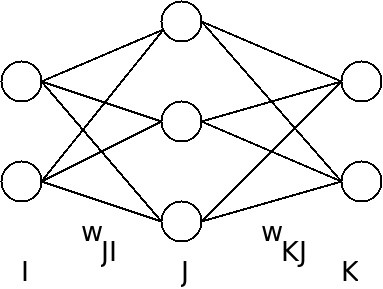

Primul strat, cel al intrărilor, este stratul $I$. Intrările vin dim matricea $X$ a sample-urilor, care are dimensiunea $(m, n)$. Primul set de ponderi este $w_{JI}$ (remarcaţi vă rog notaţia inversată). Acesta este conectat la stratul ascuns (hidden) $J$, cu activările $a_J$. Acestea se propagă prin ponderile $w_{KJ}$ către ultimul strat $K$.

Vom folosi $I$, $J$ şi $K$ atât pentru a referi primul, cel ascuns respectiv ultimul strat, cât şi pentru a le da o dimensiune. În exemplul considerat, pentru învăţarea setului MNIST cu 10 clase de digiţi, $I = 28 * 28 = 784$, dat de dimensiunea imaginii, $J=100$ (ales) iar $K=10$, dat de cele 10 clase de ieşire. Dimensiunea stratului ascuns ($J=100$) poate fi modificată; o dimensiune prea mică duce la performanţe slabe, în vreme ce o dimensiune prea mare îngreunează şi mai mult calculul (ar fi bine sa aveţi la dispoziţie minim 2GB RAM liberi).

Notând cu $a$ activările calculate şi cu $f(\cdot)$ funcţiile de activare (vor fi tanh respectiv softmax pentru ultimul strat), procesul de propagare înainte (forward propagation) poate fi scris concis sub forma următoare:

$a_I = X$

$a_J = f(z_J) = f(w_{JI} \cdot a_I + b_{JI})$

$a_K = f(z_K) = f(w_{KJ} \cdot a_J + b_{KJ})$

Folosim notaţia:

$net_K = z_K = w_{KJ} \cdot a_J + b_{KJ}$ 

pentru calcularea produselor scalare dintre liniile lui $w_{KJ}$ şi vectorul linie $a_J$; în realitate va fi o înmulţire si suma de matrice. 

Activările $a_I$ şi $a_J$ vor fi de fapt matrice; $a_I$ ştim deja că este matricea $X$ de dimensiune $(m, n)$, unde $m=20$ va fi dimensiunea batch-ului iar $n = I = 28 * 28 = 784$; $a_J$ de dimensiune $(m, J) = (20, 100)$ iar $a_K$ de dimensiune $(m, K) = (20, 10)$. 

Ponderile straturilor vor avea dimensiunile: $w_{JI}$, $(J, I) = (100, 784)$ iar $w_{KJ}$, $(K, J) = (10, 100)$. $b_{JI}$ va fi de dimensiune $(100,)$ iar $b_{KJ}$ de dimensiune $(10,)$.

## 2. Calculul gradientului pentru ponderile ultimului strat

Funcţia de activare de pe ultimul strat este în cazul nostru $a_k = softmax(z_k)$. Ieşirea acesteia face obiectul funcţiei de cost, care este

$E(a_k) = crossentropy(a_k)$

Avem aşadar compunerea de funcţii

$E(w_{KJ}) = crossentropy(softmax(w_{KJ} \cdot a_J + b_{KJ}))$

Folosind chain rule, putem scrie derivata parţială a funcţiei de cost în raport cu ponderile de pe ultimul strat:

$\frac{\partial E}{\partial w_{kj}} = \frac{\partial E}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{kj}} = \frac{\partial E}{\partial a_k} \cdot \frac{\partial a_k}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{kj}} = crossentropy'(a_k) \cdot softmax'(z_k) \cdot a_j$

Relaţia se poate scrie mai compact ca:

$\nabla_{w_{KJ}} E = \delta_{a_K} \cdot a_J$, unde am notat vectorial:

$\delta_{a_K} = crossentropy'(a_K) \cdot softmax'(z_K)$

### Calculul lui $\delta_{a_K}$

Vom ţine seama de definiţia funcţiei cross entropy $E$:

$E(z, y) = - \sum_i y_i \log( softmax( z_i ))$

Revenind la notaţia pe o singură dimensiune, avem:

$\delta_{a_k} = \frac{\partial E}{\partial z_k} = - \frac{\partial}{\partial z_k} \left( \sum_i y_i \log(softmax(z_i)) \right) = - \sum_i y_i \frac{1}{softmax(z_i)} \frac{\partial}{\partial z_k} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right)$

Ultimul termen este derivata funcţiei $softmax$. Acesta necesită un tratament separat, pentru că $z_k$-ul după care se derivează poate să fie (sau nu) $z_i$-ul de la numitor:

a) pentru $k=i$:

$\frac{\partial softmax(z_i)}{\partial z_{k=i}} = \frac{\partial}{\partial z_i} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right) = softmax(z_i) \left[ 1 - softmax(z_i) \right]$

b) pentru $k \neq i$:

$\frac{\partial softmax(z_i)}{\partial z_{k}} = \frac{\partial}{\partial z_k} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right) = - softmax(z_i) \cdot softmax(z_k)$

Revenind, $\delta_{a_k}$ devine:

$\delta_{a_k} = \frac{\partial E}{\partial z_k} = - \sum_{i \neq k} y_i \frac{1}{softmax(z_i)} (-1) softmax(z_i) \cdot softmax(z_k) - y_k \frac{1}{softmax(z_k)} softmax(z_k) \left[ 1 - softmax(z_k) \right] = softmax(z_k) \sum_i y_i - y_k = softmax(z_k) - y_k$

Adică:

$\delta_{a_K} = softmax(z_K) - y_K$, dacă scriem relaţia vectorial.

Puteţi găsi întregul raţionament detaliat [aici](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba).


### Revenirea la notaţie

Gradienţii devin astfel:

$\nabla_{w_{KJ}} E = \delta_{a_K} \cdot a_J$

$\nabla_{b_{KJ}} E = \delta_{a_K}$, cu

$\delta_{a_K} = softmax(z_K) - y_K$

De remarcat faptul că $\delta_{a_K}$ este un vector de $K$ elemente iar $a_J$ un vector de $J$ elemente; prin înmulţirea primului vector (coloană) cu al doilea vector (linie) se generează matricea $w_{KJ}$.

## 3. Calculul gradientului pentru ponderile stratului intermediar (regula propagării înapoi, backpropagation)

Ne interesează şi gradientul funcţiei de cost în raport cu ponderile stratului intermediar. Avem:

$\frac{\partial E}{\partial w_{ji}} = \sum_k \frac{\partial E}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{ji}} = \sum_k \delta_{a_k} \cdot \frac{\partial z_k}{\partial z_j} \cdot \frac{\partial z_j}{\partial w_{ji}} = \sum_k \delta_{a_k} \cdot w_{kj} \cdot f'(z_j) \cdot a_i = f'(z_j) \left[ \sum_k \delta_{a_k} w_{kj} \right] a_i = \delta_{a_j} \cdot a_i$

Vectorial, putem scrie expresia mai compact astfel:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$, respectiv:

$\nabla_{b_{JI}} E = \delta_{a_J}$, unde: 

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

La fel, de remarcat faptul că $\delta_{a_J}$ este un vector de $J$ elemente iar $a_I$ un vector de $I = n$ elemente; prin înmulţirea primului vector (coloană) cu al doilea vector (linie) se generează matricea $w_{JI}$.

## 4. Prelucrarea setului de date

In [23]:
train_set: np.ndarray = pd.read_csv('./data/mnist_train.csv', header=None).values
test_set: np.ndarray = pd.read_csv('./data/mnist_test.csv', header=None).values

Procesarea presupune separarea primului element din fiecare linie ca fiind eticheta $y$. Vom face acelaşi lucru şi pentru setul de train şi pentru cel de test:

In [24]:
train_x, train_y = train_set[:, 1:], train_set[:, 0]
test_x, test_y = test_set[:, 1:], test_set[:, 0]

# verificăm că setul de train este separat în sample-uri şi etichete:
assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)

# la fel şi pentru setul de test:
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

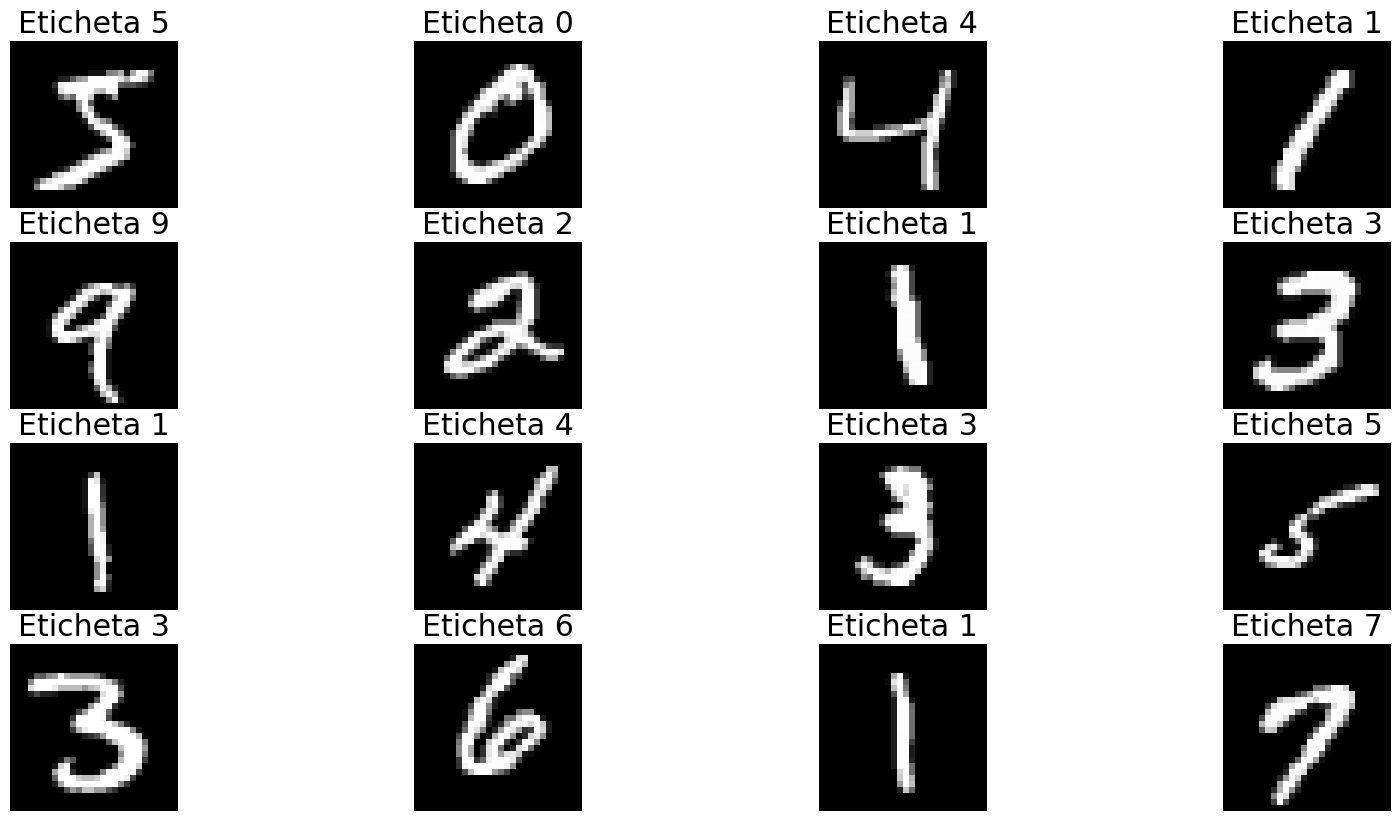

In [25]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16], train_y[:16])

In [26]:
def normalize(x: np.ndarray)-> np.ndarray:
    """
    Normalizarea înseamnă împărţirea cu 255
    
    Args:
        x: matricea feature-uridef plot(self, values, accurracies, values_validation, accurracies_validation):
        fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
        ax[0].plot([x * 10 for x in range(len(values))], values, color="red")
        ax[0].plot([x * 10 for x in range(len(values_validation))], values_validation, color="yellow")
        ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
        ax[0].grid()
        ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, color="magenta")
        ax[1].plot([x * 10 for x in range(len(accurracies_validation))], accurracies_validation, color="green")
        ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
        ax[1].grid()
        plt.show()lor, dimensiune m x n
    
    Returns:
        matricea cu valorile scalate in in [0, 1], dimensiune m x n
    """
    return x / 255

In [27]:
# în urma normalizării depunem rezultatele în aceleaşi variabile (le suprascriem)
train_x, test_x = normalize(train_x), normalize(test_x)

# valorile sample-urilor vor fi constrânse în intervalul [0, 1]
assert np.all(np.logical_and(train_x >= 0., train_x <= 1.))
assert np.all(np.logical_and(test_x >= 0., test_x <= 1.))

Deoarece folosim funcţia cross-entropy pentru antrenare, vom encoda cu 'one-hot encoding' etichetele. Matricea train_y se va transforma dintr-o matrice de dimensiune $(m, 1)$ în una de dimensiuni $(m, k)$, unde $k = 10$ (avem 10 clase).

In [28]:
def one_hot(val: int, classes = 10) -> np.ndarray:
    hot_array = np.array([1 if i == val else 0 for i in range(classes)], dtype=float).reshape([1, classes])
    return hot_array

train_y: np.ndarray = np.concatenate([one_hot(int(i)) for i in train_y])
test_y: np.ndarray = np.concatenate([one_hot(int(i)) for i in test_y])

# verificam dimensiunile
assert train_y.shape == (train_x.shape[0], 10)
assert test_y.shape == (test_y.shape[0], 10)

# verificam ca pe fiecare linie sa avem doar un 1 si restul zero-uri
assert np.all(train_y.sum(axis=1) == 1)
assert np.all(test_y.sum(axis=1) == 1)

În implementarea funcţiei de activare n-am mai folosit funcţia sigmoidă ca până acum, ci funcţia tangentă hiperbolică. Iată cum arată acestea:

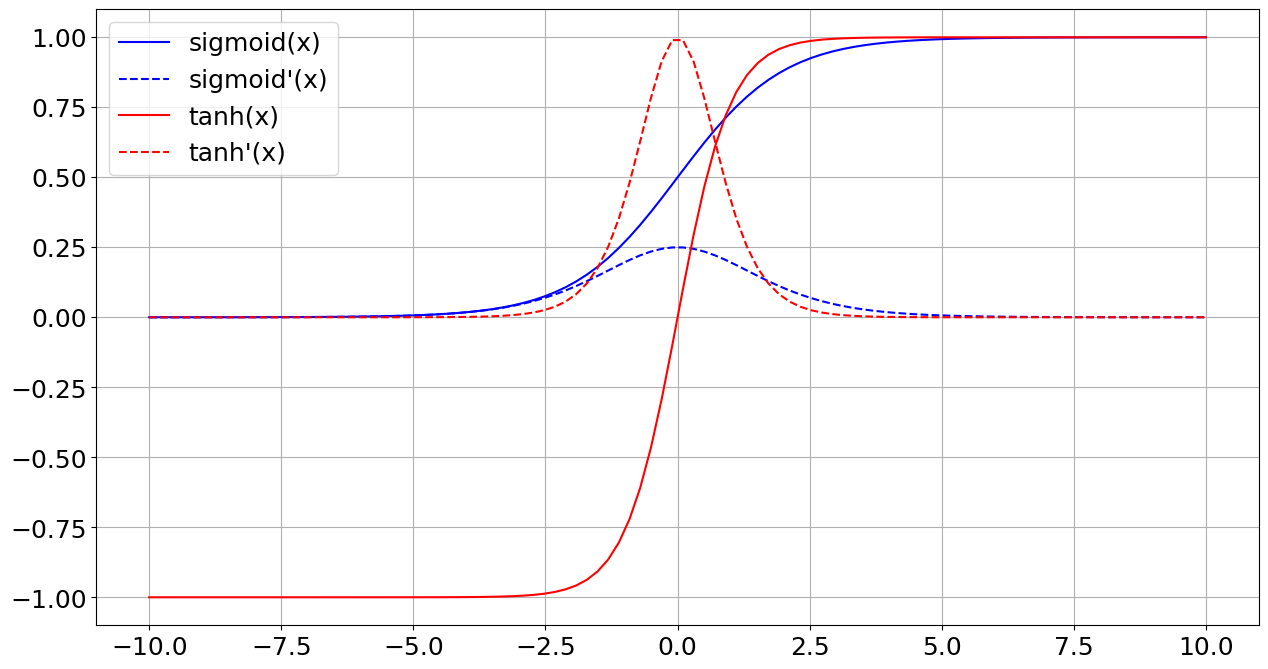

In [29]:
def represent():
    x = np.linspace(-10, 10, 100)
    sigmoid = lambda x: 1. / (1 + np.exp(-x))
    sigmoid_d = lambda x: sigmoid(x) * (1 - sigmoid(x))
    tanh = lambda x: np.tanh(x)
    tanh_d = lambda x: 1.0 - (tanh(x) ** 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.plot(x, sigmoid(x), '-', color='blue')
    ax.plot(x, sigmoid_d(x), '--', color='blue')
    ax.plot(x, tanh(x), '-', color='red')
    ax.plot(x, tanh_d(x), '--', color='red')
    ax.legend(['sigmoid(x)', "sigmoid'(x)", 'tanh(x)', "tanh'(x)"])
    ax.grid() ; plt.show()
    
represent()

Avem următoarele remarci:
* media funcţiei sigmoide este 0.5, faţă de 0.0 a lui tanh;
* media derivatei sigmoidei este 0.076 faţă de 0.154 a derivatei lui tanh.

Tangenta hiperbolică prezintă o serie de avantaje:

* tanh este simetrică faţă de 0. Aplicarea ei va produce tot valori de ieşire în acest interval (valorile de ieşire sunt intrări pentru stratul următor);
* convergenţa este mai rapidă dacă toate activările reţelei au media zero şi dispersie 1, şi sunt decorelate.

Pentru o intrare negativă, ieşirea în cazul funcţiei sigmoide se saturează la 0. Acest lucru nu se întâmplă în cazul funcţiei tanh(), o intrare negativă determină o activare negativă. Prin acest comportament, funcţia sigmoidă poate determina reţeaua să se blocheze în minime locale, procesul de învăţare decurgând mai lent.

Mai multe detalii puteţi găsi în articolul lui [Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

## 5. Implementarea funcţiei softmax

In [30]:
# Cerinta: executia acestei celule nu trebuie sa duca la avertismentul RuntimeWarning: overflow encountered in exp

def sigmoid(z: np.ndarray):
    """
    Calculeaza functie de activare pentru un vector sau o matrice
    """
    return np.tanh(z)

def sigmoid_derivative(z: np.ndarray):
    """
    Calculeaza valorile derivatelor pe vectorul/matricea z 
    """
    return 1.0 - (np.tanh(z) ** 2)

def softmax(z: np.ndarray):
    """
    Args:
        z: numar de coloane egal cu numarul de clase. Numarul de linii al lui zeste dat de dimensiunea minibatchului.
        Pentru stabilitate numerica, aplicati trucul din sectiunea 3.4.3 a cursului
    Returns:
        pe fiecare linie se aplica functia softmax. Valorile rezulatte trebuie sa defineasca o distributie de probabilitate
    """
    z_copy = np.copy(z)
    z_copy -= np.max(z_copy, axis=1, keepdims=True) # shift values
    e_z = np.exp(z_copy)
    return e_z / np.sum(e_z, axis=1, keepdims=True)

# verificam ca softmax-ul sa fie calculat corect
a = np.random.randn(100, 40) * 10000
assert a.shape == softmax(a).shape
assert np.all(softmax(a) >= 0)
assert np.allclose(softmax(a).sum(axis=1), 1)
assert softmax(a).sum(axis=1).shape == (a.shape[0],)
del a

## 6. Implementarea propagării înainte (forward)

Scopul este să evaluăm strat cu strat întreaga reţea, pornind de la intrare. Activările primului strat sunt chiar sample-urile setului de date $X$ (minibatch-ul).

Se vor calcula z-urile pentru fiecare strat:

$z = a \cdot w^T + b^T$, respectiv activarile următoare:

$a = sigmoid(z)$, respectiv funcţia $softmax()$ pentru ultimul strat.

De exemplu, intrarea $a_I$ are dimensiunea $(m, I)$, m fiind numarul de date din minibatch. Ponderile primului strat $w_{JI}$ au dimensiunea $(J, I)$, deci activarea $a_J = f(a_I \cdot w_{JI}^T + b_{JI}^T)$ va avea dimensiunea $(m, J)$ - vom folosi înmulţirea matricială pentru calculul lui $z_{J}$.

In [31]:
def forward(set_x: np.ndarray, weights: np.ndarray, biases: np.ndarray):
    """
    Propagarea înainte prin reţea, cu calcularea net-urilor şi activărilor.
    Atenţie că activările de pe ultimul strat se calculează cu funcţia softmax() în loc de sigmoid().
    
    Args:
        set_x: setul de intrare de dimensiune (m, I)
        weights: lista de matrice de ponderi; nu se modifica in acest pas
        biases: lista de vectori de termeni liberi; nu se modifica in acest pas
        
    Returns:
        activations: lista de activari
        nets: lista de net-uri (z)
    """
    activations, nets = [set_x, None, None], [None, None, None] # cele doua liste vor avea in final aceeasi lungime
    nets[1] = activations[0] @ weights[0].T + biases[0].T
    activations[1] = sigmoid(nets[1])
    nets[2] = activations[1] @ weights[1].T + biases[1].T
    activations[2] = softmax(nets[2])
    return activations, nets

inputs = np.ones((3, 25)) * 0.5

# Stratul ascuns are J=10 neuroni iar ultimul (softmax) are K=4.
weights = np.array([np.ones((10, 25)) * 0.2, np.ones((4, 10)) * 0.3], dtype=object)
weights_backup = [item.copy() for item in weights]
biases: np.ndarray = np.array([np.ones((10,)) * 0.1, np.ones((4,)) * 0.1], dtype=object)
biases_backup = [item.copy() for item in biases]

activations, nets = forward(inputs, weights, biases)
# Pentru 3 straturi, se vor calcula 3 activări şi 2 net-uri în cele două liste rezultate; primul net din list este None:
assert len(activations) == len(nets) == 3

# Verificam forma activarilor
assert activations[0].shape == inputs.shape == (3, 25)
assert activations[1].shape == (3, 10)
assert activations[2].shape == (3, 4)
assert np.abs(np.linalg.norm(activations[0]) - 4.330127) < 1e-6
assert np.abs(np.linalg.norm(activations[1]) - 5.4171262) < 1e-6
assert np.abs(np.linalg.norm(activations[2]) - 0.8660254) < 1e-6

# Verificam forma net-urilor
assert nets[0] is None
assert nets[1].shape == (3, 10)
assert nets[2].shape == (3, 4)
assert np.abs(np.linalg.norm(nets[1]) - 14.2407865) < 1e-6
assert np.abs(np.linalg.norm(nets[2]) - 10.6246844) < 1e-6

# verificam ca nu s-au modificat ponderile in timpul forward propagation

assert all(np.all(w == w_bak) for w, w_bak in zip(weights, weights_backup))
assert all(np.all(b == b_bak) for b, b_bak in zip(biases, biases_backup))

del weights_backup, biases_backup

## 7. Implementarea propagării înapoi (backward propagation)

Propagarea înapoi are drept scop calcularea gradientului pentru fiecare strat. Pentru aceasta, va trebui să determinăm $\delta$ asociat pentru fiecare strat începând de la ultimul.

Atenţie că aceşti $\delta$ nu sunt vectori coloană, ci matrici, cu prima dimensiune dimensiunea batch-ului şi a doua dimensiune dimensiunea stratului. Pe baza lui $\delta$ veţi determina gradientul, prin medierea folosind dimensiunea batch-ului (prima dimensiune).

O complicaţie din cauza dimensiunii batch-ului apare la următoarea relaţie:

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

Aici, $\delta_{a_K}$ are dimensiunea $(m, K)$ iar prin înmulţirea cu $w_{KJ}$ se generează o matrice de dimensiuni $(m, J)$, aceleaşi cu cele ale lui $f'(z_j)$.

O a doua complicaţie apare tot din cauza dimensiunii batch-ului la relaţiile de calcul a gradientului:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$

Aici, $\delta_{a_J}$ are dimensiunea $(m, J)$ iar $a_I$, $(m, I)$. Pentru a înmulţi primii $m$ vectori coloană cu ceilalţi $m$ vectori linie, folosim batch matrix multiplication - înmulţire normală de matrici doar pentru ultimele două dimensiuni, pentru fiecare element din dimensiunea 0. Adică redimensionăm $(m, J) \rightarrow (m, J, 1)$ iar $(m, I) \rightarrow (m, 1, I)$, iar prin înmulţirea lor matricială obţinem $(m, J, I)$. Reducem prin mediere prima dimensiune.

In [32]:
def backward(weights: np.ndarray, biases: np.ndarray, activations: np.ndarray, nets: np.ndarray, set_y: np.ndarray):
    """
    Propagă delta spre intrarea reţelei începând de la ultimul strat
    
    Args:
        weights: lista de ponderi
        biases: lista de elemente libere
        activations: lista de activari, calculata de forward
        nets: lista de z-uri, calculata de forward
        set_y: etichetele, one-hot encoded
        
    Returns:
        delta_w, delta_b: update-urile gradientilor
    """
    
    assert len(weights) == len(biases) 
    assert len(activations) == len(nets)
    assert nets[0] is None
    
    # declara delta-urile
    delta_b = np.zeros_like(biases)
    delta_w = np.zeros_like(weights)

    m = activations[-3].shape[0]

    delta_k = (softmax(nets[-1]) - set_y)
    delta_w[-1] = (activations[-2].T @ delta_k).T / m # plus l2 regularization
    delta_b[-1] = np.mean(delta_k, axis=0, keepdims=True)

    delta_j = (delta_k @ weights[-1]) * sigmoid_derivative(nets[-2])
    delta_w[-2] = (activations[-3].T @ delta_j).T / m # plus l2 regularization
    delta_b[-2] = np.mean(delta_j, axis=0, keepdims=True)

    delta_b[0] = delta_b[0].ravel()
    delta_b[1] = delta_b[1].ravel()

    return delta_w, delta_b

labels = np.concatenate([one_hot(int(i), 4) for i in np.array([1, 0, 3])])
delta_w, delta_b = backward(weights, biases, activations, nets, labels)

# verificam consistenta raspunsurilor
assert len(delta_w) == len(delta_b) == 2
assert delta_w[0].shape == (10, 25)
assert delta_w[1].shape == (4, 10)
assert delta_b[0].shape == (10,)
assert delta_b[1].shape == (4,)
assert np.linalg.norm(delta_w[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_w[1]) - 0.9028543) < 1e-6
assert np.linalg.norm(delta_b[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_b[1]) - 0.2886751) < 1e-6

## 8. Calculul unui batch şi a acurateţii

Constă din propagarea înainte, propagarea înapoi, urmate de ajustarea ponderilor.

In [33]:
def compute_batch(batch_x, batch_y, weights, biases, alpha, lmbda):
    """ 
    Realizeaza cei doi pasi pentru fiecare batch in parte
    
    Args:
        batch_x: sample-urile de intrare
        batch_y: etichetele lor
        weights: lista cu ponderile reţelei
        biases: lista cu termenii liberi
        alpha: rata de învăţare
        lmbda: parametrul de regularizare
        
    Returns:
        weights, biases: noile ponderi după actualizarea lor cu gradienţii calculaţi
    """
    activations, nets = forward(batch_x, weights, biases)
    delta_w, delta_b = backward(weights, biases, activations, nets, batch_y)

    weights = weights - alpha * (delta_w + lmbda * weights)
    biases = biases - alpha * delta_b
    
    return weights, biases

Acurateţea presupune inspectarea etichetelor şi compararea lor cu rezultatul produs de reţea:

In [34]:
def accuracy(set_x, set_y, weights, biases):
    """ 
    Calculeaza iesirea sub forma de one-hot encoding folosind feedforward(),
    si o foloseste pentru a numara cate sample-uri sunt antrenate corect
    
    Args:
        set_x: sample-urile, de dimensiune (m, n)
        set_y: etichetele, de dimensiune (m, n_classes)
        weights: lista ponderilor reţelei
        biases: lista termenilor liberi
        
    Returns:
        procentul de sample-uri clasificate corect
    """
    # ... call forward()
    activations, _ = forward(set_x, weights, biases)
    pred =  np.argmax(activations[-1], axis=1)
    actual = np.argmax(set_y, axis=1)
    res = pred == actual
    return 100 * res.sum() / res.shape[0]

assert np.abs(accuracy(inputs, labels, weights, biases) - 33.3333333) < 1e-6

In [35]:
def crossentropy_loss(set_y: np.ndarray, output: np.ndarray):
    return -1 / output.shape[0] * np.sum(set_y * np.log(output))

## 9. Antrenarea reţelei şi evaluarea pe setul de test

In [36]:
sizes = [28 * 28, 100, 10]
scale = 1 / np.sqrt(train_x.shape[0])

weights = np.array([np.random.normal(loc=0, scale=scale, size = (j, i)) for i, j in zip(sizes[:-1], sizes[1:])], dtype=object)
biases = np.array([np.random.normal(loc=0, scale=scale, size = (i,)) for i in sizes[1:]], dtype=object)

alpha = 0.2
batch_size = 20 # pentru aceasta dimensiune de batch, consumul de memorie este la 1.5 GB
lmbda = 0.001
epochs = 20

train_acc = []
test_acc = []
train_values = []
test_values = []

for epoch in range(epochs):
    # generarea unei permutari aleatoare a sample-urilor din set
    perm = np.random.permutation(train_x.shape[0])
    # generare de lista de liste de indici din permutare: lista primilor batch_size indici indica primul batch, etc
    index_batches = [perm[k:k+batch_size] for k in range(0, train_x.shape[0], batch_size)]
    assert set(item for sublist in index_batches for item in sublist) == set(range(train_x.shape[0]))
    
    # generarea batch-urilor folosind acea permutare aleatoare
    x_batches = [train_x[idx] for idx in index_batches]
    y_batches = [train_y[idx] for idx in index_batches]

    # rularea batch-urilor si schimbarea ponderilor retelei
    for (batch_x, batch_y) in zip(x_batches, y_batches):
        weights, biases = compute_batch(batch_x, batch_y, weights, biases, alpha, lmbda)
    
    train_accuracy = accuracy(train_x, train_y, weights, biases)
    test_accuracy = accuracy(test_x, test_y, weights, biases)

    print(f'epoch: {epoch}, train accuracy: {train_accuracy:.2f}, test accuracy: {test_accuracy:.2f}')

    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    activations_train, _ = forward(train_x, weights, biases)
    activations_test, _ = forward(test_x, weights, biases)

    train_values.append(crossentropy_loss(train_y, activations_train[2]))
    test_values.append(crossentropy_loss(test_y, activations_test[2]))
    alpha *= 0.8

epoch: 0, train accuracy: 94.61, test accuracy: 94.38
epoch: 1, train accuracy: 96.40, test accuracy: 95.91
epoch: 2, train accuracy: 96.94, test accuracy: 96.52
epoch: 3, train accuracy: 97.39, test accuracy: 96.82
epoch: 4, train accuracy: 97.39, test accuracy: 96.94
epoch: 5, train accuracy: 97.37, test accuracy: 96.96
epoch: 6, train accuracy: 97.82, test accuracy: 97.30
epoch: 7, train accuracy: 97.66, test accuracy: 97.15
epoch: 8, train accuracy: 97.91, test accuracy: 97.33
epoch: 9, train accuracy: 97.94, test accuracy: 97.33
epoch: 10, train accuracy: 98.01, test accuracy: 97.35
epoch: 11, train accuracy: 98.00, test accuracy: 97.31
epoch: 12, train accuracy: 98.03, test accuracy: 97.45
epoch: 13, train accuracy: 98.06, test accuracy: 97.38
epoch: 14, train accuracy: 98.01, test accuracy: 97.41
epoch: 15, train accuracy: 98.05, test accuracy: 97.43
epoch: 16, train accuracy: 98.06, test accuracy: 97.36
epoch: 17, train accuracy: 98.09, test accuracy: 97.38
epoch: 18, train acc

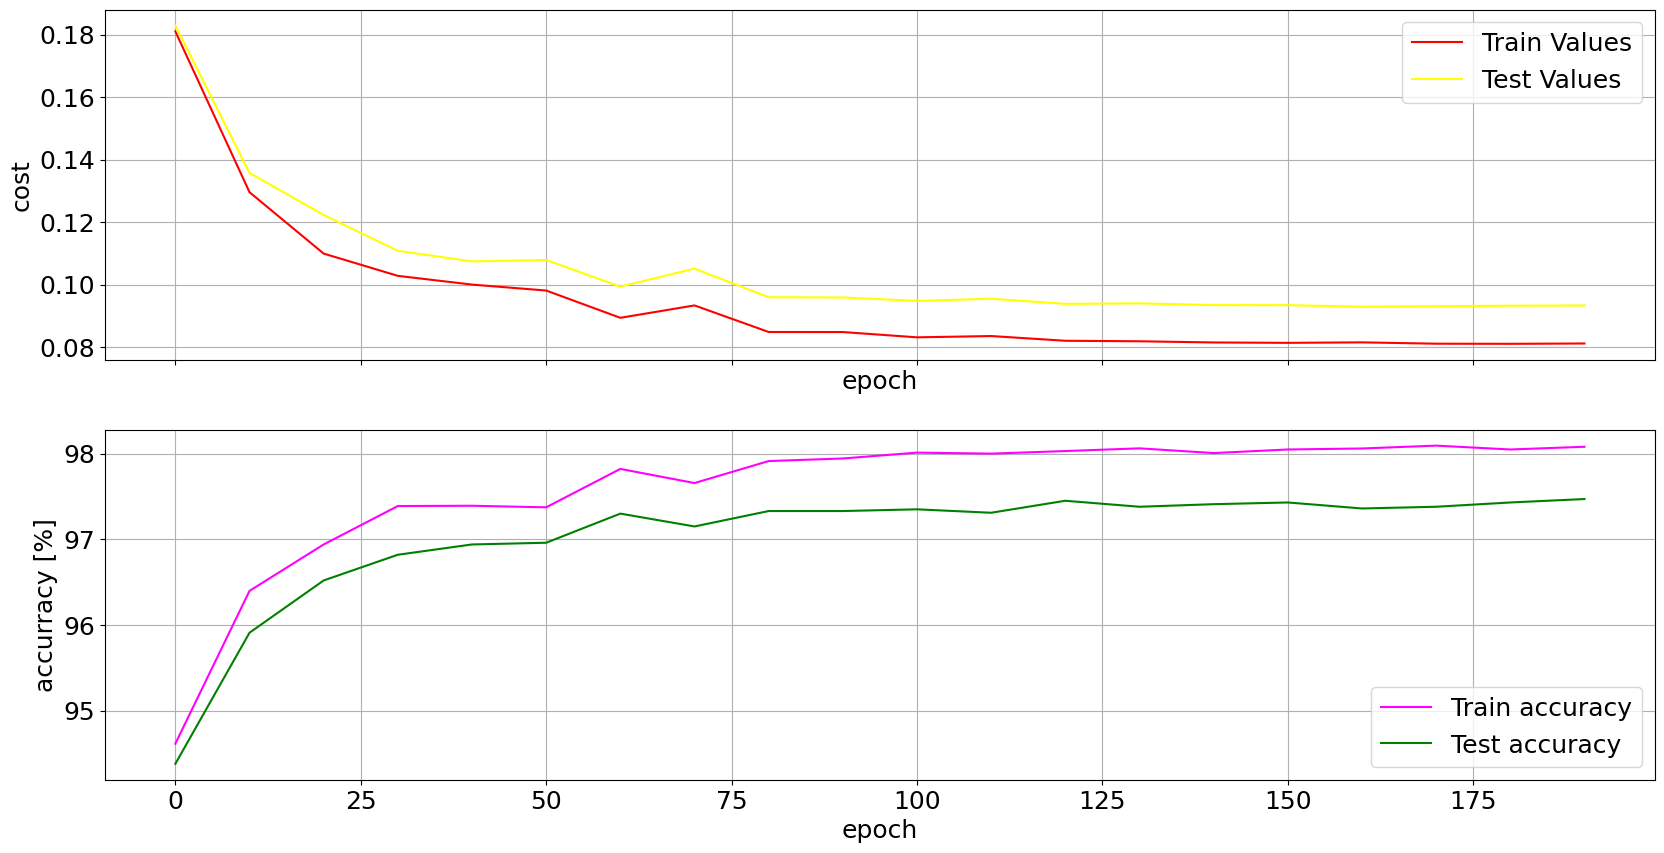

In [37]:
def plot(values, accurracies, values_validation, accurracies_validation):
        fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
        ax[0].plot([x * 10 for x in range(len(values))], values, color="red")
        ax[0].plot([x * 10 for x in range(len(values_validation))], values_validation, color="yellow")
        ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
        ax[0].legend(['Train Values', 'Test Values'])
        ax[0].grid()
        ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, color="magenta")
        ax[1].plot([x * 10 for x in range(len(accurracies_validation))], accurracies_validation, color="green")
        ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
        ax[1].legend(['Train accuracy', 'Test accuracy'])
        ax[1].grid()
        plt.show()
plot(train_values, train_acc, test_values, test_acc)

In [38]:
def print_confusion_matrix(set_x: np.ndarray, set_y: np.ndarray):
    import tableprint as tab
    actual = set_y
    activations, _  = forward(set_x, weights, biases)
    pred = activations[2]
    pred_classes = np.argmax(pred, axis=1)
    actual_classes = np.argmax(actual, axis=1)

    k = set_y.shape[1]
    conf_matrix = np.zeros((k, k), dtype=int)
    for i in range(len(actual)):
        conf_matrix[actual_classes[i], pred_classes[i]] += 1

    assert len(conf_matrix) == k
    assert (sum(len(row) for row in conf_matrix)) == k ** 2

    headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a']
    table = []
    for i in range(k):
        row = [f'act: {i}'] + list(conf_matrix[i, :]) + [np.sum(conf_matrix[i, :])]
        table.append(row)
    table.append(['all p'] + list(np.sum(conf_matrix, axis=0)) + [np.sum(conf_matrix)])

    tab.table(table, headers, width=6)
print_confusion_matrix(test_x, test_y)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    970 │      0 │      1 │      1 │      0 │      2 │      4 │      1 │      1 │      0 │    980 │
│ act: 1 │      0 │   1124 │      2 │      1 │      0 │      1 │      3 │      1 │      3 │      0 │   1135 │
│ act: 2 │      6 │      1 │    997 │      4 │      3 │      0 │      4 │      9 │      8 │      0 │   1032 │
│ act: 3 │      0 │      0 │      5 │    991 │      0 │      1 │      0 │      7 │      4 │      2 │   1010 │
│ act: 4 │      1 │      0 │      1 │      0 │    959 │      1 │      6 │      2 │      2 │     10 │    982 │
│ act: 5 │      4 │      1 │      0 │      8 │      0 │    866 │      7 │      1 │      3 │      2 │    892 │
│ act: 6 │

## 10. Suplimentar (si obligatoriu)

1. Pe un alt grafic sa se prezinte: accuratetea pe setul de antrenare si pe setul de testare, la finalul fiecarei epoci (ambele scoruri pe acelasi grafic, cu legenda).
1. Sa se calculeze si afiseze matricea de confuzie. 

## 11. Suplimentar (optional)
1. Pe un grafic sa se prezinte loss-ul la finalul fiecarei epoci, pe setul de antrenare. Functia de loss este aceeasi ca in logistic regression, cazul multinomial
1. Implementati modificare de ponderi folosind metoda momentum.
1. Matricea de confuzie ca procent + colorare heatmap.